

---



> **Dog Breed Detection**



---





---



> **DATASET CODE**


---








```
# First we need a API key('kaggle.json') to access the dataset from the kaggle server.
```





In [1]:
#it will make a folder in room directory
! mkdir ~/.kaggle

In [2]:
# it will the 'kaggle.json' copy in kaggle folder in root.
! cp kaggle.json ~/.kaggle/

In [3]:
# 'chmod 600' this command give the user full access to read and write 
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
#it is private key command to download the specific dataset zip from kaggle server
! kaggle competitions download -c dog-breed-identification

100% 688M/691M [00:04<00:00, 223MB/s]
100% 691M/691M [00:04<00:00, 168MB/s]


In [5]:
#it will unzip the downloaded file
! unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84



---



> **MAIN CODE**



---



In [6]:
# load all required libraries for Dog's Breed Identification Project
import cv2
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [7]:
#read the csv file
df_labels = pd.read_csv("labels.csv")
#store training and testing images folder location
train_file = 'train/'
test_file = 'test/'

In [8]:
#check the total number of unique breed in our dataset file
print("Total number of unique Dog Breeds :",len(df_labels.breed.unique()))

Total number of unique Dog Breeds : 120


In [9]:
#specify number
num_breeds = 60
im_size = 224
batch_size = 64
encoder = LabelEncoder()

In [10]:
#get only 60 unique breeds record 
breed_dict = list(df_labels['breed'].value_counts().keys()) 
new_list = sorted(breed_dict,reverse=True)[:num_breeds*2+1:2]
#change the dataset to have only those 60 unique breed records
df_labels = df_labels.query('breed in @new_list')

In [11]:
#create new column which will contain image name with the image extension
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")

In [12]:
#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(df_labels), im_size, im_size, 3), dtype='float32')
 
#iterate over img_file column of our dataset
for i, img_id in enumerate(df_labels['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
  img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
  img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
  train_x[i] = img_array

In [13]:
#This will be the target for the model.
#convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)

In [14]:
#split the dataset in the ratio of 80:20. 
#80% for training and 20% for testing purpose
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

In [15]:
#Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
 
#generate images for training sets 
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=batch_size)
 
#same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()
 
test_generator = test_datagen.flow(x_test, 
                                     y_test, 
                                     batch_size=batch_size)

In [16]:
#building the model using ResNet50V2 with input shape of our image array
#weights for our network will be from of imagenet dataset
#we will not include the first Dense layer
resnet = ResNet50V2(input_shape = [im_size,im_size,3], weights='imagenet', include_top=False)
#freeze all trainable layers and train only top layers 
for layer in resnet.layers:
    layer.trainable = False
 
#add global average pooling layer and Batch Normalization layer
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
#add fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

94668760/94668760 [==============================] - 1s 0us/step


In [17]:
#add output layer having the shape equal to number of breeds
predictions = Dense(num_breeds, activation='softmax')(x)
 
#create model class with inputs and outputs
model = Model(inputs=resnet.input, outputs=predictions)
#model.summary()

In [18]:
#epochs for model training and learning rate for optimizer
epochs = 20
learning_rate = 1e-3
 
#using RMSprop optimizer to compile or build the model
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
 
#fit the training generator data and train the model
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)
 
#Save the model for prediction
model.save("model")

Epoch 1/20
64/64 [==============================] - 827s 13s/step - loss: 2.2664 - accuracy: 0.4301 - val_loss: 0.8099 - val_accuracy: 0.7402
Epoch 2/20
64/64 [==============================] - 868s 14s/step - loss: 1.2492 - accuracy: 0.6325 - val_loss: 0.6993 - val_accuracy: 0.7832
Epoch 3/20
64/64 [==============================] - 864s 14s/step - loss: 1.1285 - accuracy: 0.6644 - val_loss: 0.6293 - val_accuracy: 0.8066
Epoch 4/20
64/64 [==============================] - 831s 13s/step - loss: 1.0256 - accuracy: 0.6884 - val_loss: 0.6860 - val_accuracy: 0.7881
Epoch 5/20
64/64 [==============================] - 868s 14s/step - loss: 0.9673 - accuracy: 0.7031 - val_loss: 0.6649 - val_accuracy: 0.7900
Epoch 6/20
64/64 [==============================] - 863s 14s/step - loss: 0.9152 - accuracy: 0.7186 - val_loss: 0.6647 - val_accuracy: 0.7949
Epoch 7/20
64/64 [==============================] - 872s 14s/step - loss: 0.9200 - accuracy: 0.7215 - val_loss: 0.6582 - val_accuracy: 0.7910
Epoch 

1/1 [==============================] - 1s 1s/step


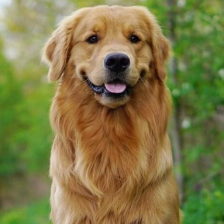

Predicted Breed for this Dog is : golden_retriever


In [26]:
from google.colab.patches import cv2_imshow
#load the model
model = load_model("model")
 
#get the image of the dog for prediction
pred_img_path = 'Golden_Retriever.png'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
 
#display the image of dog
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))) 
 
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)